In [ ]:
# run on colab

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.2/529.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 25.6 MB/s eta 0:00:00


In [ ]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from ultralytics import YOLO
import albumentations as A
import numpy as np
import os
import pandas as pd

In [ ]:
model_y = YOLO('/content/drive/MyDrive/colab/weight/v8m_best.pt')

In [ ]:
model_m = tf.keras.models.load_model('/content/drive/MyDrive/colab/weight/mn_mix_132-0.98.h5')

In [ ]:
class_names = ['pet_clear', 'pet_mixed']

In [ ]:
y_class_names = {
    0: 'furniture',
    1: 'metal',
    2: 'wood',
    3: 'pottery',
    4: 'vinyl',
    5: 'styrofoam',
    6: 'glass',
    7: 'cloth',
    8: 'bike',
    9: 'electro',
    10:'paper',
    11:'can',
    12:'pet',
    13:'plastic',
    14:'light',
   }

In [ ]:
img_path = '/content/drive/MyDrive/colab/weight/test_img/mixed/'

In [ ]:
img_list = os.listdir(img_path)

In [ ]:
def transform_img(img) :
    transform = A.Compose([
        A.LongestMaxSize(max_size=224, interpolation=1),
        A.PadIfNeeded(min_height=224, min_width=224, border_mode=0, value=(0,0,0)),
    ])
    
    transformed = transform(image=img)
    tf_img = transformed['image']
    tf_img = tf_img.reshape(1,224,224,3)
    
    return tf_img
    

In [ ]:
def box_xyxy(box) :
    [x1,y1,x2,y2] = box.xyxy.cpu().numpy()[0]
    return int(x1), int(y1), int(x2), int(y2)

/content/drive/MyDrive/colab/weight/test_img/mixed/t3_0016.jpg


image 1/1 /content/drive/MyDrive/colab/weight/test_img/mixed/t3_0016.jpg: 384x640 2 papers, 1 pet, 25.4ms
Speed: 0.6ms preprocess, 25.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step


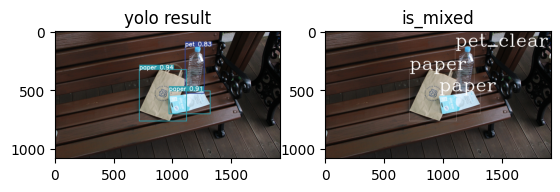

/content/drive/MyDrive/colab/weight/test_img/mixed/t3_0030.jpg


image 1/1 /content/drive/MyDrive/colab/weight/test_img/mixed/t3_0030.jpg: 384x640 2 pets, 25.4ms
Speed: 0.5ms preprocess, 25.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step


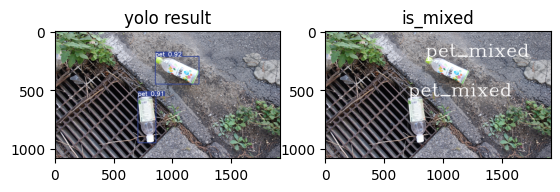

In [ ]:
for img_file in img_list :

    target = os.path.join(img_path,img_file)
    print(target)

    #yolo prediction
    y_result = model_y(target,conf=0.25,iou=0.7)
    y_plotted = y_result[0].plot()
    y_plotted = cv2.cvtColor(y_plotted,cv2.COLOR_BGR2RGB)

    img = y_result[0].orig_img
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    #bounding box by yolo
    boxes = y_result[0].boxes

    for box in boxes :

        x1,y1,x2,y2 = box_xyxy(box)
        y_class = y_class_names[box.cls.item()]
        y_conf = round(box.conf.item(),3)

        #clear/mixed pet prediction by mobilenet
        if y_class == 'pet' :
            obj = img[int(y1):int(y2),int(x1):int(x2)]
            tf_obj_img = transform_img(obj)

            [m_pred] = model_m.predict(tf_obj_img)
            y_class = class_names[m_pred.argmax()]
            y_conf = round(m_pred.max(),3)
    
        img= cv2.rectangle(img,(int(x1),int(y1)),(int(x2),int(y2)),(255,255,255),1)
        img = cv2.putText(img,y_class,(int(x1),int(y1)),cv2.FONT_HERSHEY_COMPLEX,5,(255,255,255),5)

    plt.subplot(1, 2, 1)  
    plt.title('yolo result')
    plt.imshow(res_plotted)

    plt.subplot(1, 2, 2)  
    plt.title('is_mixed')
    plt.imshow(img)
    plt.show()



